In [1]:
!git clone https://github.com/mhagiwara/universalscripts
%cd universalscripts

fatal: destination path 'universalscripts' already exists and is not an empty directory.
/Users/mhagiwara/dev/universalscripts/universalscripts


In [2]:
%pip install Pillow
%pip install torch
%pip install torchvision

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%mkdir data/chars
%mkdir -p result/vae

mkdir: data/chars: File exists


In [4]:
import torch
import torch.utils.data
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
from PIL import Image
import PIL.ImageOps

In [5]:
def split_chars():
    image = Image.open('data/chars.png')
    r, g, b, a = image.split()
    image = Image.merge('RGB', (r, g, b))

    image = PIL.ImageOps.invert(image)

    x_offset = 8
    y_offset = 6
    for x in range(40):
        for y in range(21):
            box = (x_offset + x * 48, y_offset + y * 48,
                   x_offset + x * 48 + 32, y_offset + y * 48 + 32)
            region = image.crop(box)
            region.save('data/chars/{:02d}{:02d}.png'.format(x, y))


In [6]:
split_chars()

In [7]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
NUM_HIDDEN = 32

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size // 4, 2, 2)


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    cross_entropy = F.binary_cross_entropy(
        recon_x, x.view(-1, IMG_WIDTH * IMG_HEIGHT), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_distance = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return cross_entropy + kl_distance

In [10]:
def generate_random(model, epoch):
    from torch.distributions.normal import Normal
    images = []
    for x in range(10+1):
        for y in range(10+1):

            z = torch.randn(NUM_HIDDEN).unsqueeze(0)
            recon = model.decoder(model.fc3(z))
            images.append(recon)

    images_joined = torch.cat(images).view(-1, 1, IMG_WIDTH, IMG_HEIGHT)
    save_image(images_joined.cpu(),
               'result/vae/epoch{:03d}.png'.format(epoch), nrow=11)

In [11]:
def train_vae():
    seed = 1
    batch_size = 32
    epochs = 100
    log_interval = 10

    torch.manual_seed(seed)

    transform = transforms.Compose([transforms.Grayscale(),
                                    transforms.ToTensor()])
    chars = datasets.folder.ImageFolder('data/', transform=transform)
    train_loader = torch.utils.data.DataLoader(chars, batch_size=batch_size, shuffle=True)

    model = VAE(image_channels=1, h_dim=IMG_HEIGHT * IMG_WIDTH, z_dim=NUM_HIDDEN)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))

        model.eval()
        generate_random(model, epoch)

    torch.save(model.state_dict(), 'result/vae/model.pt')


In [12]:
train_vae()

/Users/mhagiwara/dev/universalscripts/.pyenv/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([32, 1024])) that is different to the input size (torch.Size([32, 1, 32, 32])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [0/840 (0%)]	Loss: 798.324341
Train Epoch: 1 [320/840 (37%)]	Loss: 608.176880
Train Epoch: 1 [640/840 (74%)]	Loss: 471.463409


/Users/mhagiwara/dev/universalscripts/.pyenv/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([8, 1024])) that is different to the input size (torch.Size([8, 1, 32, 32])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> Epoch: 1 Average loss: 579.9380
Train Epoch: 2 [0/840 (0%)]	Loss: 441.842163
Train Epoch: 2 [320/840 (37%)]	Loss: 356.961334
Train Epoch: 2 [640/840 (74%)]	Loss: 314.787567
====> Epoch: 2 Average loss: 362.9164
Train Epoch: 3 [0/840 (0%)]	Loss: 313.601562
Train Epoch: 3 [320/840 (37%)]	Loss: 313.451263
Train Epoch: 3 [640/840 (74%)]	Loss: 339.398621
====> Epoch: 3 Average loss: 326.9901
Train Epoch: 4 [0/840 (0%)]	Loss: 312.402069
Train Epoch: 4 [320/840 (37%)]	Loss: 298.132141
Train Epoch: 4 [640/840 (74%)]	Loss: 342.099365
====> Epoch: 4 Average loss: 311.0809
Train Epoch: 5 [0/840 (0%)]	Loss: 310.388489
Train Epoch: 5 [320/840 (37%)]	Loss: 312.443329
Train Epoch: 5 [640/840 (74%)]	Loss: 282.783813
====> Epoch: 5 Average loss: 304.1641
Train Epoch: 6 [0/840 (0%)]	Loss: 299.240570
Train Epoch: 6 [320/840 (37%)]	Loss: 279.781372
Train Epoch: 6 [640/840 (74%)]	Loss: 289.098022
====> Epoch: 6 Average loss: 296.7778
Train Epoch: 7 [0/840 (0%)]	Loss: 322.788116
Train Epoch: 7 [320/84

====> Epoch: 46 Average loss: 162.7895
Train Epoch: 47 [0/840 (0%)]	Loss: 190.068024
Train Epoch: 47 [320/840 (37%)]	Loss: 149.058014
Train Epoch: 47 [640/840 (74%)]	Loss: 165.730515
====> Epoch: 47 Average loss: 159.5742
Train Epoch: 48 [0/840 (0%)]	Loss: 152.222656
Train Epoch: 48 [320/840 (37%)]	Loss: 145.535187
Train Epoch: 48 [640/840 (74%)]	Loss: 140.086243
====> Epoch: 48 Average loss: 157.9539
Train Epoch: 49 [0/840 (0%)]	Loss: 175.892090
Train Epoch: 49 [320/840 (37%)]	Loss: 163.760925
Train Epoch: 49 [640/840 (74%)]	Loss: 139.223846
====> Epoch: 49 Average loss: 156.9213
Train Epoch: 50 [0/840 (0%)]	Loss: 150.582733
Train Epoch: 50 [320/840 (37%)]	Loss: 167.912689
Train Epoch: 50 [640/840 (74%)]	Loss: 193.505280
====> Epoch: 50 Average loss: 154.7091
Train Epoch: 51 [0/840 (0%)]	Loss: 148.824188
Train Epoch: 51 [320/840 (37%)]	Loss: 137.161972
Train Epoch: 51 [640/840 (74%)]	Loss: 144.433990
====> Epoch: 51 Average loss: 153.5388
Train Epoch: 52 [0/840 (0%)]	Loss: 154.605713


====> Epoch: 91 Average loss: 121.1900
Train Epoch: 92 [0/840 (0%)]	Loss: 123.349274
Train Epoch: 92 [320/840 (37%)]	Loss: 125.631210
Train Epoch: 92 [640/840 (74%)]	Loss: 136.093002
====> Epoch: 92 Average loss: 121.5649
Train Epoch: 93 [0/840 (0%)]	Loss: 108.731270
Train Epoch: 93 [320/840 (37%)]	Loss: 122.854500
Train Epoch: 93 [640/840 (74%)]	Loss: 106.850113
====> Epoch: 93 Average loss: 120.4529
Train Epoch: 94 [0/840 (0%)]	Loss: 116.188446
Train Epoch: 94 [320/840 (37%)]	Loss: 136.776352
Train Epoch: 94 [640/840 (74%)]	Loss: 113.861092
====> Epoch: 94 Average loss: 120.0499
Train Epoch: 95 [0/840 (0%)]	Loss: 142.929581
Train Epoch: 95 [320/840 (37%)]	Loss: 126.270737
Train Epoch: 95 [640/840 (74%)]	Loss: 114.463211
====> Epoch: 95 Average loss: 119.7754
Train Epoch: 96 [0/840 (0%)]	Loss: 117.019928
Train Epoch: 96 [320/840 (37%)]	Loss: 134.270691
Train Epoch: 96 [640/840 (74%)]	Loss: 109.913208
====> Epoch: 96 Average loss: 120.0557
Train Epoch: 97 [0/840 (0%)]	Loss: 108.878799


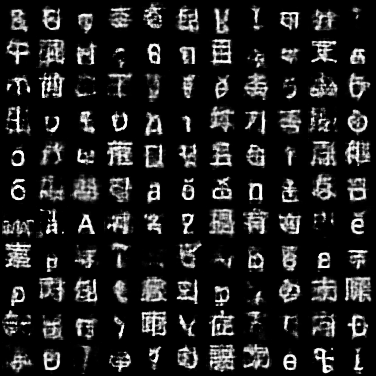

In [13]:
Image.open('result/vae/epoch080.png')